In [593]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from scipy import optimize
import inspect
import h5py

In [594]:
%matplotlib notebook

In [595]:
import sys
sys.path.append('../../nadavp/new_trap/PythonScripts/')
import BeadDataFile
from discharge_tools import *

In [596]:
def trans_func(data, axis, fit_type = 1, fsamp = 0, harm_freq = 0, w0_guess= 1, g_guess = 1, a_guess = 1, b_guess = 1):
    if fsamp == 0:
        return 'Must Input Sampling Frequency!'
    
    freq,psd = data.psd2(axis)
    fft = np.sqrt(psd)
    
    unfiltered_peaks = signal.find_peaks(np.log(fft))[0]
    harmonics_0 = [peak for peak in unfiltered_peaks if freq[peak]%harm_freq == 0]
    harmonics_index = np.asarray([harm for harm in harmonics_0 if harmonics_0.index(harm)<50 ])
    
    def fit_2(x,a,w,g,b):
        x_ang = 2*np.pi*x
        return a*w/np.sqrt(((w**2-x_ang**2)**2 + (g*x_ang-(b**3)/x_ang)**2))
    
    def fit_1(x,a,w,g):
        x_ang = 2*np.pi*x
        return a*w/np.sqrt(((w**2-x_ang**2)**2 + (g*x_ang)**2))
    
    if fit_type==1:
        curve = optimize.curve_fit(fit_1,freq[harmonics_index],fft[harmonics_index],p0 = [a_guess, w0_guess,g_guess])
        pars = curve[0]
        var = np.asarray([curve[1][0][0], curve[1][1][1], curve[1][2][2]])
    elif fit_type ==2:
        curve = optimize.curve_fit(fit_2,freq[harmonics_index],fft[harmonics_index],p0 = [a_guess, w0_guess,g_guess,b_guess])
        pars = curve[0]
        var = np.asarray([curve[1][0][0], curve[1][1][1], curve[1][2][2], curve[1][3][3]])
    
    return freq[harmonics_index],fft[harmonics_index],pars,var

## Load data

In [597]:
fname = r'/data/new_trap/20190626/Bead1/Discharge/Discharge_10.h5'
bd = BeadDataFile.BeadDataFile(fname)
object_methods = [method_name for method_name in dir(bd)
                  if callable(getattr(bd, method_name))]
inspect.getsourcelines(bd.psd2)

No cantilever data


(['    def psd2(self, str_axis, res = 2**12):\n',
  '        x = [] \n',
  "        if str_axis=='x':\n",
  '            x = self.x2\n',
  "        elif str_axis=='y':\n",
  '            x = self.y2\n',
  "        elif str_axis=='z':\n",
  '            x = self.z2\n',
  '        else:\n',
  "            print('Must choose x,y,or z')\n",
  '\n',
  "        fft = np.abs(np.fft.rfft(x,norm='ortho'))**2 \n",
  '        freq = np.fft.rfftfreq(len(x), d=1./self.fsamp)\n',
  '\n',
  '        return freq, fft\n'],
 112)

In [598]:
def fit(x,a,w,g):
    x_ang = 2*np.pi*x
    return a*w/np.sqrt(((w**2-x_ang**2)**2 + (g**2)*(x_ang**2)))

## ODE Used for Z Transfer Function:
### $$ \ddot{x} + \gamma \dot{x} + w_0^2 x + \beta^3 \int^{t}_{0}x(t')dt' = f(t)$$

## Transfer Function from ODE:
### $$ G(\omega)=\frac{A \omega}{\sqrt{(\omega_0^2 - \omega^2)^2 + (\gamma \omega - \frac{\beta^3}{\omega})^2}} $$

In [599]:
def fit_2(x,a,w,g,b):
        x_ang = 2*np.pi*x
        return a*w/np.sqrt(((w**2-x_ang**2)**2 + (g*x_ang-(b**3)/x_ang)**2))

In [600]:
file_z = r'/data/new_trap/20190708/Bead2/TransFunc/TransFuncZ_18.h5'
TF_z = BeadDataFile.BeadDataFile(file_z)

f_z,ft_z,par_z, var_z= trans_func(TF_z,fit_type =2,axis = 'z', fsamp = 5000, harm_freq = 23, a_guess = 1e7, w0_guess = 2000, g_guess = 3000, b_guess = 762)


No cantilever data


<IPython.core.display.Javascript object>


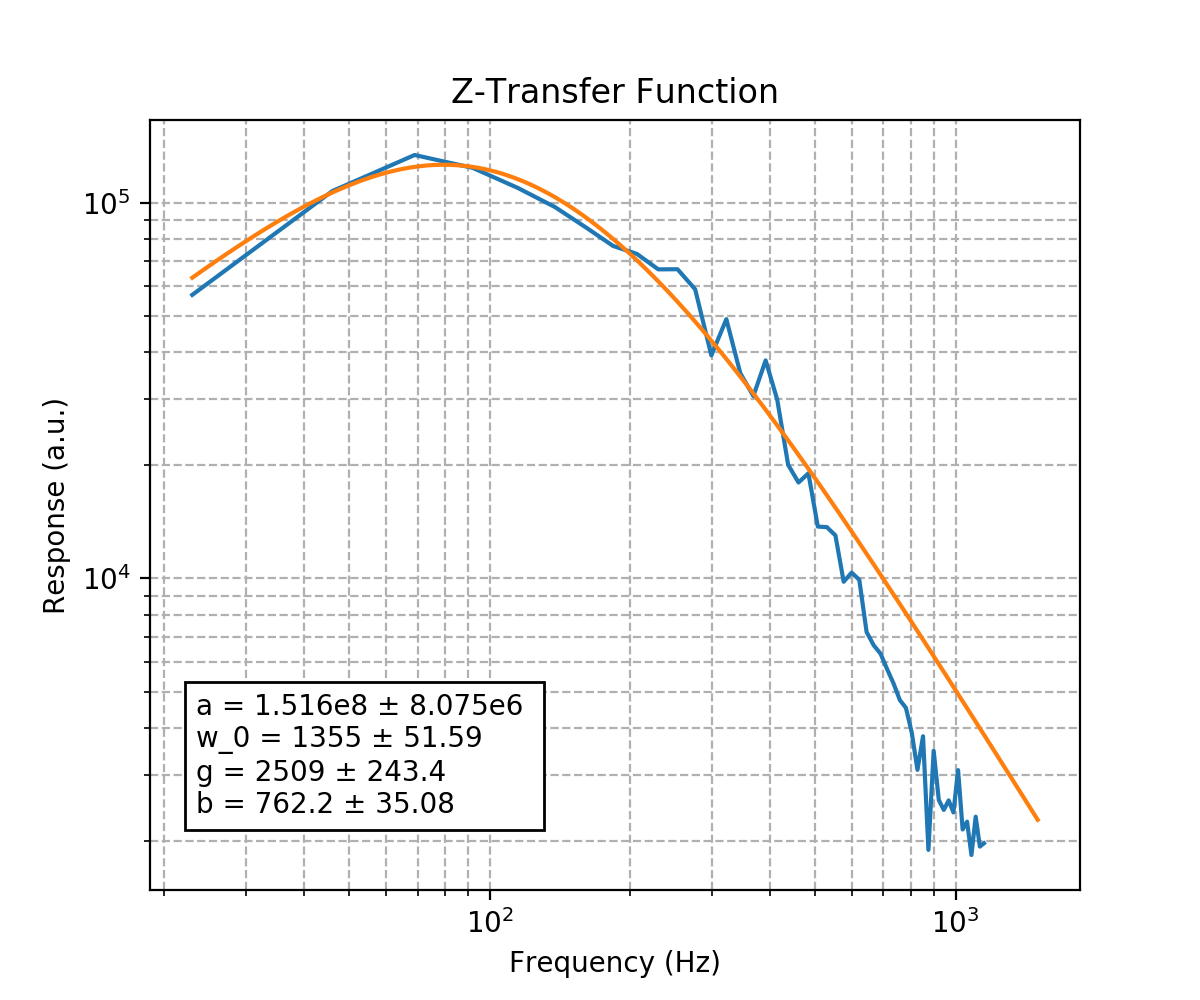

param= 151608674.98552608 1355.626497923292 2509.346661199252 762.2567365213697 var= 8075054.396443161 51.59199703695299 243.4361941229377 35.08168592045283


In [601]:
_,ax = plt.subplots(figsize=(6,5))
ax.grid(which ='both', ls = 'dashed')
m = np.linspace(23,1500,1000)
ax.plot(f_z,ft_z)
ax.loglog(m,fit_2(m,*par_z))
ax.text(0.05,0.1, 'a = 1.516e8 ± 8.075e6 \nw_0 = 1355 ± 51.59\ng = 2509 ± 243.4\nb = 762.2 ± 35.08',transform=ax.transAxes, bbox = {'facecolor' :'white'})
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response (a.u.)')
ax.set_title('Z-Transfer Function')
print('param=', *par_z, 'var=', *var_z**(1/2))

In [602]:
file_x = r'/data/new_trap/20190708/Bead2/TransFunc/TransFuncX_14.h5'
TF_x = BeadDataFile.BeadDataFile(file_x)

f_x,ft_x,par_x,var_x= trans_func(TF_x,fit_type = 1,axis = 'x', fsamp = 5000, harm_freq = 23, a_guess = 1e3, w0_guess = 1e3, g_guess = 1e3)

No cantilever data


<IPython.core.display.Javascript object>


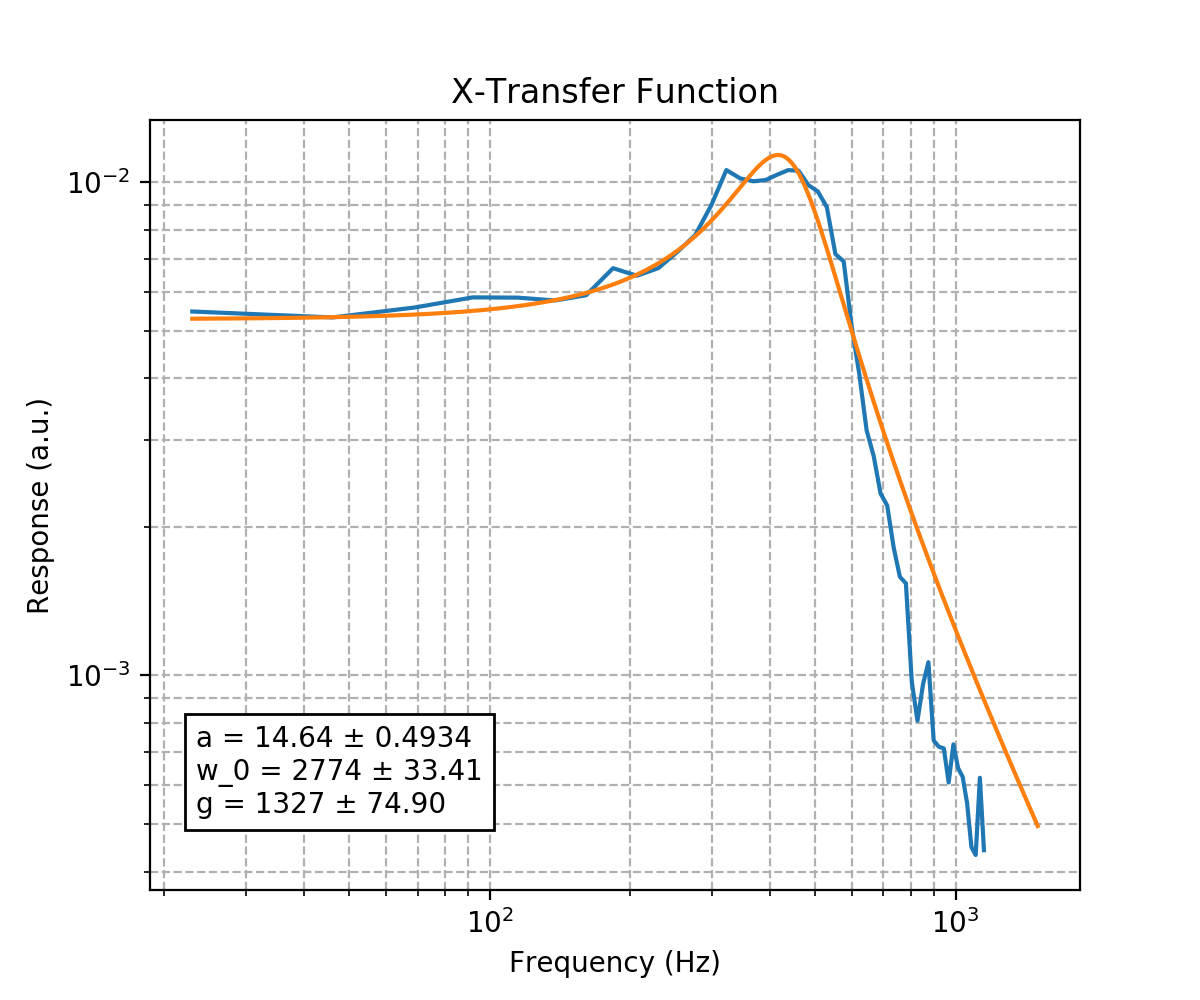

param= 14.638375843343981 2774.938891933125 1327.2886245304035 var= 0.49339972442387303 33.41357502249161 74.89953047623946


In [603]:
_,ax = plt.subplots(figsize=(6,5))
ax.grid(which ='both', ls = 'dashed')
m = np.linspace(23,1500,1000)
ax.plot(f_x,ft_x)
ax.loglog(m,fit(m,*par_x))
ax.text(0.05,0.1, 'a = 14.64 ± 0.4934 \nw_0 = 2774 ± 33.41\ng = 1327 ± 74.90',transform=ax.transAxes, bbox = {'facecolor' :'white'})
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response (a.u.)')
ax.set_title('X-Transfer Function')
print('param=', *par_x, 'var=', *var_x**(1/2))

In [604]:
file_y = r'/data/new_trap/20190708/Bead2/TransFunc/TransFuncY_16.h5'
TF_y = BeadDataFile.BeadDataFile(file_y)

f_y,ft_y,par_y,var_y = trans_func(TF_y,fit_type = 1,axis = 'y', fsamp = 5000, harm_freq = 23, a_guess = 1e3, w0_guess = 1e3, g_guess = 1e3)

No cantilever data


<IPython.core.display.Javascript object>


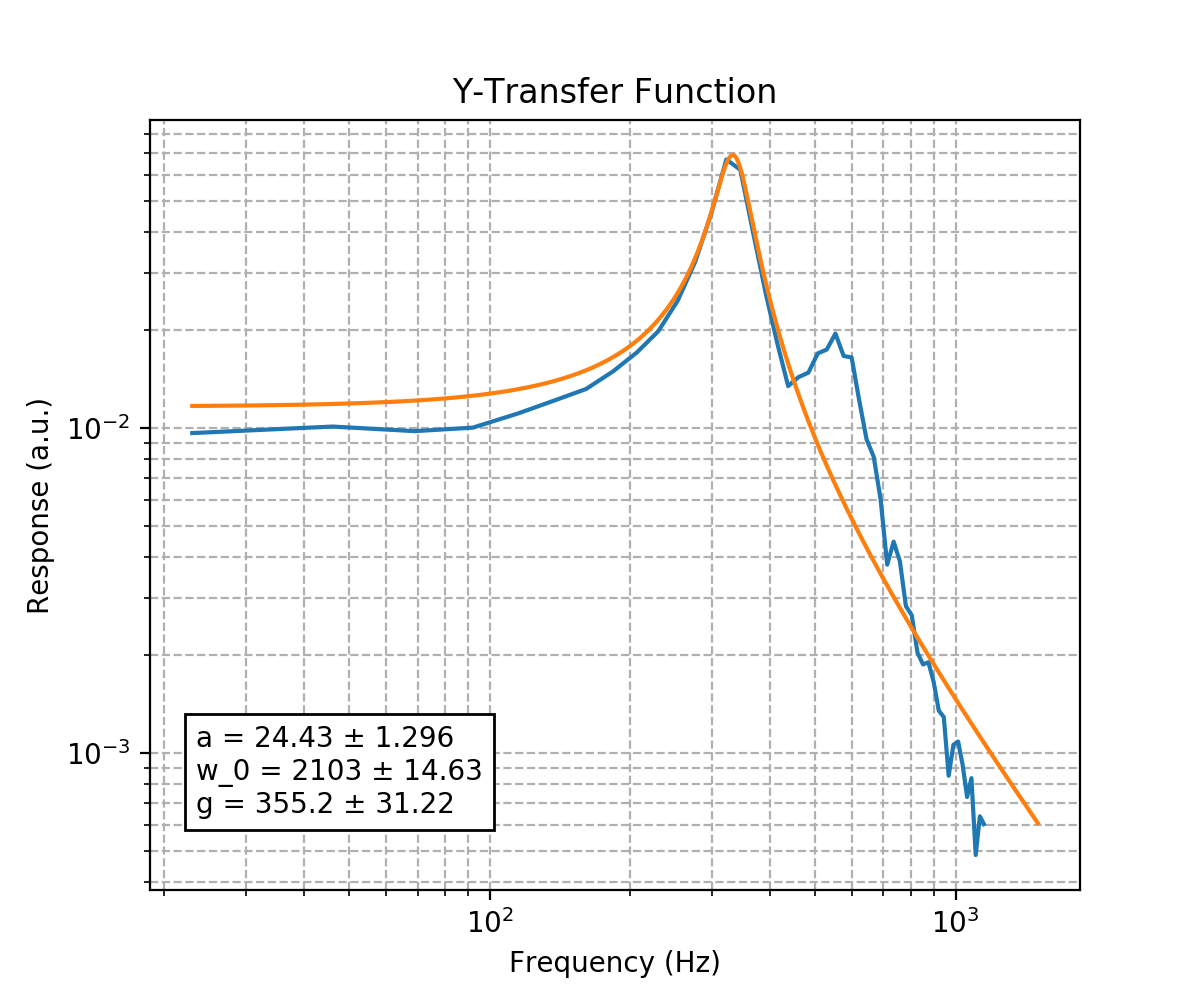

param= 24.433079625451484 2103.494923097658 -355.1672467740071 var= 1.295883225672518 14.633834212553184 31.21628072160938


In [605]:
_,ax = plt.subplots(figsize=(6,5))
ax.grid(which ='both', ls = 'dashed')
m = np.linspace(23,1500,1000)
ax.plot(f_y,ft_y)
ax.loglog(m,fit(m,*par_y))
ax.text(0.05,0.1, 'a = 24.43 ± 1.296\nw_0 = 2103 ± 14.63\ng = 355.2 ± 31.22',transform=ax.transAxes, bbox = {'facecolor' :'white'})
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response (a.u.)')
ax.set_title('Y-Transfer Function')
print('param=', *par_y, 'var=', *var_y**(1/2))

## Undriven Gas Damped Bead Transfer Functions

In [606]:
file_2 = r'/data/new_trap/20190712/Bead1/InitialTest/Data0.h5'
bead_data = BeadDataFile.BeadDataFile(file_2)

No cantilever data


<IPython.core.display.Javascript object>


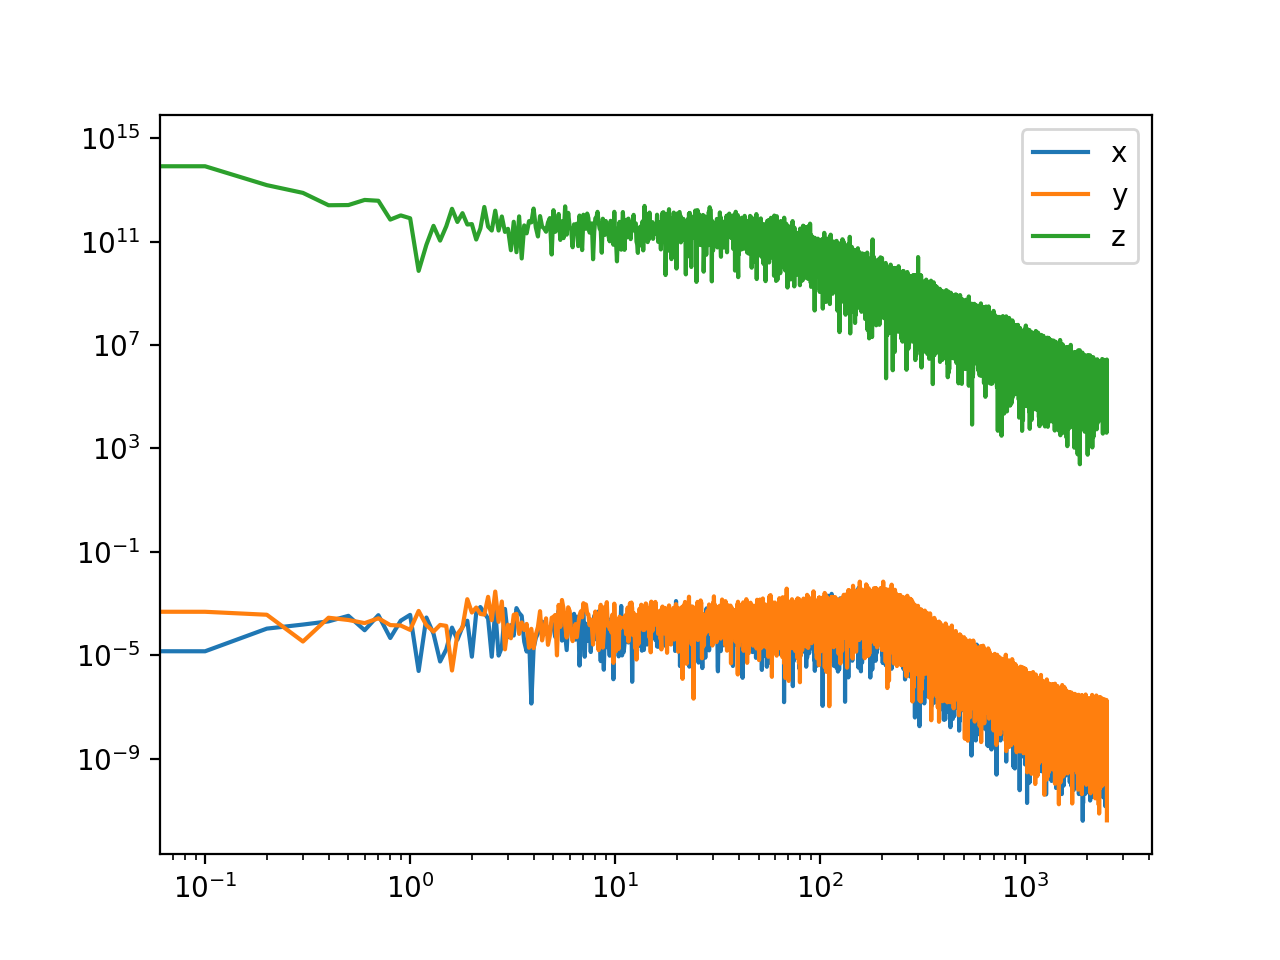

In [607]:
_,ax = plt.subplots()
ax.loglog(*bead_data.psd2('x'), label = 'x')
ax.loglog(*bead_data.psd2('y'), label = 'y')
ax.loglog(*bead_data.psd2('z'), label = 'z')
ax.legend()

In [615]:
x_freq, x_fft = bead_data.psd2('x')[0], bead_data.psd2('x')[1]**(1/2)
p_index_x = signal.find_peaks(x_fft, distance = 10)[0]
x_freq_peaks = x_freq[p_index_x]
x_fft_peaks = x_fft[p_index_x]

y_freq, y_fft = bead_data.psd2('y')[0],bead_data.psd2('y')[1]**(1/2)
p_index_y = signal.find_peaks(y_psd, distance = 10)[0]
y_freq_peaks = y_freq[p_index_y]
y_fft_peaks = y_fft[p_index_y]

z_freq, z_fft = bead_data.psd2('z')[0], bead_data.psd2('z')[1]**(1/2)
p_index_z = signal.find_peaks(z_fft, distance = 10)[0]
z_freq_peaks = z_freq[p_index_z]
z_fft_peaks = z_fft[p_index_z]

In [616]:
curve_x = optimize.curve_fit(fit, x_freq_peaks, x_fft_peaks, p0 = [1e10,1000,100])
curve_y = optimize.curve_fit(fit, y_freq_peaks, y_fft_peaks, p0 = [1e10,1000,100])
curve_z = optimize.curve_fit(fit, z_freq_peaks, z_fft_peaks, p0 = [1e20,1e2,100])
params_x = curve_x[0]
params_y = curve_y[0]
params_z = curve_z[0]
var_x = np.asarray([curve_x[1][0][0], curve_x[1][1][1], curve_x[1][2][2]])
var_y = np.asarray([curve_y[1][0][0], curve_y[1][1][1], curve_y[1][2][2]])
var_z = np.asarray([curve_z[1][0][0], curve_z[1][1][1], curve_z[1][2][2]])

<IPython.core.display.Javascript object>


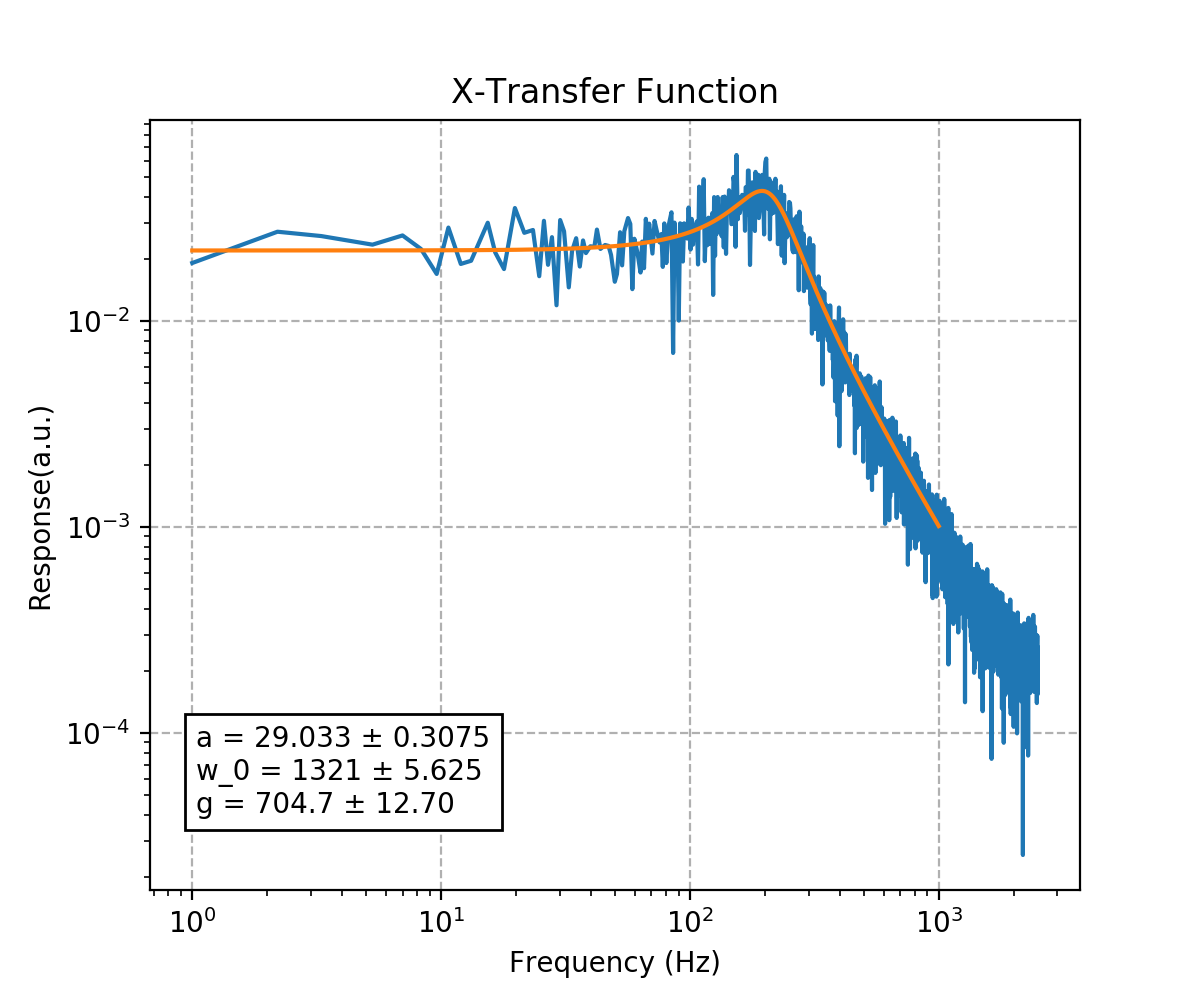

param= 29.03170016470444 1321.669387158943 704.7078045801192 var= 0.30750275526408943 5.62528892678147 12.698109490849028


In [621]:
_,ax = plt.subplots(figsize = (6,5))
n = np.linspace(1,1000,1000)
ax.loglog(x_freq_peaks, x_fft_peaks)
ax.loglog(n,fit(n,*params_x))
ax.grid(which ='major', ls = 'dashed')
ax.text(0.05,0.1, 'a = 29.033 ± 0.3075\nw_0 = 1321 ± 5.625\ng = 704.7 ± 12.70',transform=ax.transAxes, bbox = {'facecolor' :'white'})
ax.set_title('X-Transfer Function')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response(a.u.)')
print('param=',*params_x,'var=',*var_x**(1/2))

<IPython.core.display.Javascript object>


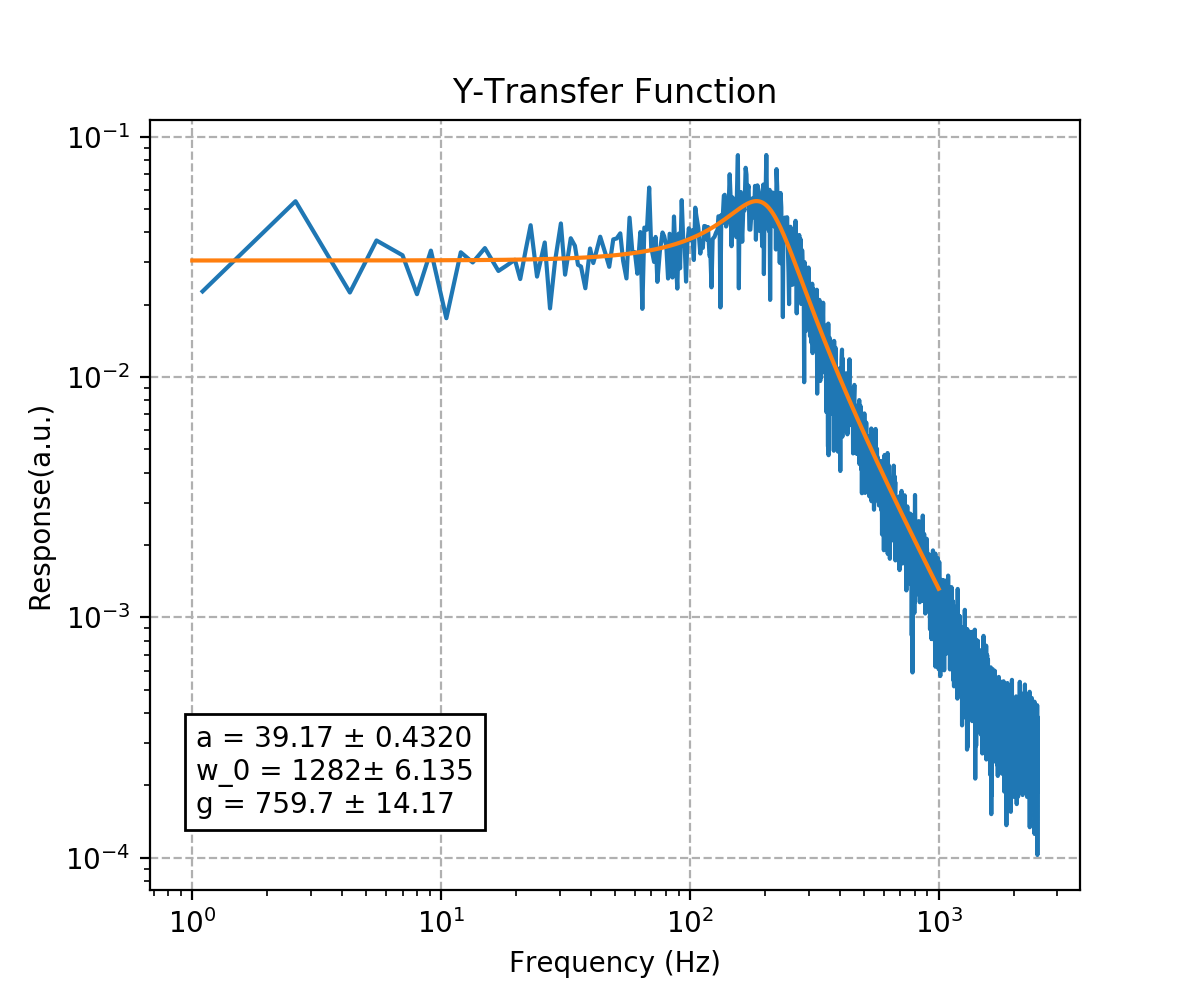

param= 39.17419794313703 1281.7420520137568 -759.7081068848465 var = 0.4320033713490582 6.134836399231737 14.174073048820622


In [622]:
_,ax = plt.subplots(figsize=(6,5))
ax.loglog(y_freq_peaks, y_fft_peaks)
ax.loglog(n,fit(n,*params_y))
ax.grid(which ='major', ls = 'dashed')
ax.text(0.05,0.1, 'a = 39.17 ± 0.4320\nw_0 = 1282± 6.135\ng = 759.7 ± 14.17',transform=ax.transAxes, bbox = {'facecolor' :'white'})
ax.set_title('Y-Transfer Function')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response(a.u.)')
print('param=',*params_y,'var =',*var_y**(1/2))

<IPython.core.display.Javascript object>


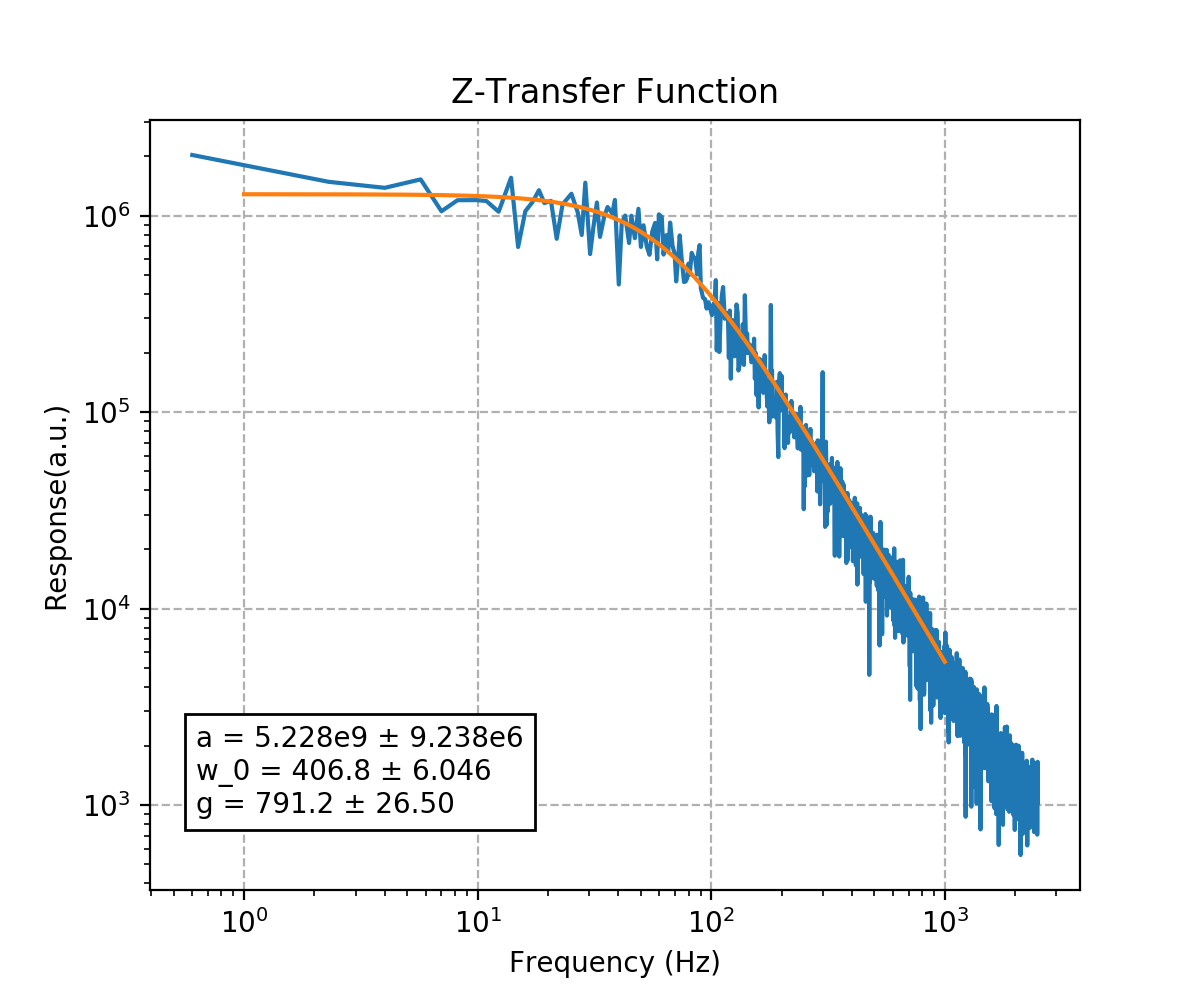

param =  522800658.61935526 406.8336624049205 791.2025302888151 var = 9237789.518205658 6.046131174504961 26.498732480596036


In [623]:
_,ax = plt.subplots(figsize=(6,5))
ax.loglog(z_freq_peaks, z_fft_peaks)
ax.loglog(n,fit(n,*params_z))
ax.grid(which ='major', ls = 'dashed')
ax.text(0.05,0.1, 'a = 5.228e9 ± 9.238e6\nw_0 = 406.8 ± 6.046\ng = 791.2 ± 26.50',transform=ax.transAxes, bbox = {'facecolor' :'white'})
ax.set_title('Z-Transfer Function')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response(a.u.)')
print('param = ',*params_z,'var =',*var_z**(1/2))

In [624]:
print('x parameters = \n w_0 =', (params_x[1]), '\n gamma =' ,(params_x[2]))
print('y parameters = \n w_0 =',(params_y[1]),'\n gamma =' ,(params_y[2]) )
print('z parameters = \n w_0 =', (params_z[1]), '\n gamma =' ,(params_z[2]) )

x parameters = 
 w_0 = 1321.669387158943 
 gamma = 704.7078045801192
y parameters = 
 w_0 = 1281.7420520137568 
 gamma = -759.7081068848465
z parameters = 
 w_0 = 406.8336624049205 
 gamma = 791.2025302888151
